# Disease Outbreak Response Decision-making Under Uncertainty: A retrospective analysis of measles in Sao Paulo

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.ma as ma
from datetime import datetime
import matplotlib.pyplot as plt
import pdb

from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
data_dir = "data/"

In [3]:
!rm -rf ~/.theano

Import outbreak data

In [4]:
measles_data = pd.read_csv(data_dir+"measles.csv", index_col=0)
measles_data.NOTIFICATION = pd.to_datetime(measles_data.NOTIFICATION)
measles_data.BIRTH = pd.to_datetime(measles_data.BIRTH)
measles_data.ONSET = pd.to_datetime(measles_data.ONSET)

In [5]:
measles_data = measles_data.replace({'DISTRICT': {'BRASILANDIA':'BRAZILANDIA'}})

Sao Paulo population by district

In [6]:
sp_pop = pd.read_csv(data_dir+'sp_pop.csv', index_col=0)

In [7]:
_names = sp_pop.index.values
_names[_names=='BRASILANDIA'] = 'BRAZILANDIA'
sp_pop.set_index(_names, inplace = True)

In [8]:
sp_pop.head()

,0 a 4 anos,5 a 9 anos,10 a 14 anos,15 a 19 anos,20 a 24 anos,25 a 29 anos,30 a 34 anos,35 a 39 anos,40 a 44 anos,45 a 49 anos,50 a 54 anos,55 a 59 anos,60 a 64 anos,65 a 69 anos,70 a 74 anos,75 anos e +,Total
AGUA RASA,5411,5750,6450,7122,7621,7340,6999,6984,6346,5608,4987,4212,4152,3595,2937,3637,89151
ALTO DE PINHEIROS,2070,2369,2953,3661,4612,4190,3539,3633,3448,3289,3040,2533,2298,1732,1305,1823,46495
ANHANGUERA,3068,3006,2755,2431,2426,2636,2695,2308,1653,1107,753,509,352,217,162,171,26249
ARICANDUVA,7732,7730,8373,8956,9182,8531,7813,7365,6551,5554,4887,3858,3320,2449,1611,1723,95635
ARTUR ALVIM,9031,9078,10000,11058,11387,10347,9125,8658,7830,7055,5919,4612,3756,2633,1727,1724,113940


Annual vaccination data

In [9]:
vaccination_data = pd.read_csv('data/BrazilVaxRecords.csv', index_col=0)
vaccination_data.head()

,BIRTHS,VAX,POP,SIA
YEAR,,,,
1980,3896442,0.57,121740438,0
1981,3933136,0.73,124610790,0
1982,3952137,0.66,127525420,0
1983,3952735,0.68,130455659,0
1984,3935224,0.73,133364277,0


In [10]:
vaccination_data.VAX[:18]

YEAR
1980    0.57
1981    0.73
1982    0.66
1983    0.68
1984    0.73
1985    0.67
1986    0.67
1987    0.64
1988    0.62
1989    0.60
1990    0.78
1991    0.85
1992    0.91
1993    0.85
1994    0.77
1995    0.87
1996    0.80
1997    0.99
Name: VAX, dtype: float64

In [11]:
vax_97 = np.r_[[0]*(1979-1921+1), vaccination_data.VAX[:17]]
n = len(vax_97)
FOI_mat = np.resize((1 - vax_97*0.9), (n,n)).T

In [12]:
# Mean age of infection for those born prior to vaccination coverage, assuming R0=16
A = 4.375

In [13]:
(1 - vax_97*0.9)[:-1]

array([ 1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  0.487,  0.343,  0.406,  0.388,  0.343,
        0.397,  0.397,  0.424,  0.442,  0.46 ,  0.298,  0.235,  0.181,
        0.235,  0.307,  0.217])

In [14]:
natural_susc = np.exp((-1/A) * np.tril(FOI_mat).sum(0))[::-1]
vacc_susc = (1 - vax_97*0.9)[::-1]
vacc_susc[0] = 0.5
vacc_susc

array([ 0.5  ,  0.217,  0.307,  0.235,  0.181,  0.235,  0.298,  0.46 ,
        0.442,  0.424,  0.397,  0.397,  0.343,  0.388,  0.406,  0.343,
        0.487,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ])

In [15]:
sia_susc = np.ones(len(vax_97))
birth_year = np.arange(1922, 1998)[::-1]
by_mask = (birth_year > 1983) & (birth_year < 1992)
sia_susc[by_mask] *= 0.2
sia_susc

array([ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  0.2,  0.2,  0.2,  0.2,  0.2,
        0.2,  0.2,  0.2,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ])

In [16]:
total_susc = sia_susc * vacc_susc * natural_susc
total_susc

array([  4.69002500e-01,   1.93697440e-01,   2.55462677e-01,
         1.85322917e-01,   1.36953286e-01,   1.68513200e-01,
         3.99236891e-02,   5.54765276e-02,   4.81834127e-02,
         4.19519164e-02,   3.58729698e-02,   3.27610800e-02,
         2.61705672e-02,   2.70916231e-02,   1.29180455e-01,
         1.00905818e-01,   1.28176341e-01,   2.09416838e-01,
         1.66626583e-01,   1.32579684e-01,   1.05489605e-01,
         8.39348576e-02,   6.67844030e-02,   5.31383100e-02,
         4.22805305e-02,   3.36413269e-02,   2.67673765e-02,
         2.12979840e-02,   1.69461555e-02,   1.34835384e-02,
         1.07284398e-02,   8.53629188e-03,   6.79206677e-03,
         5.40424011e-03,   4.29998882e-03,   3.42136979e-03,
         2.72227946e-03,   2.16603463e-03,   1.72344761e-03,
         1.37129463e-03,   1.09109726e-03,   8.68152769e-04,
         6.90762647e-04,   5.49618743e-04,   4.37314850e-04,
         3.47958071e-04,   2.76859611e-04,   2.20288738e-04,
         1.75277021e-04,

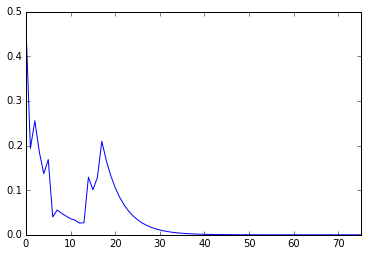

In [50]:
pd.Series(total_susc).plot();

Plot of cumulative cases by district

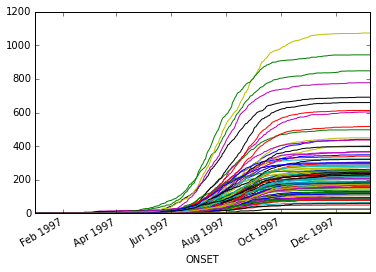

In [17]:
measles_onset_dist = measles_data.groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0)
measles_onset_dist.cumsum().plot(legend=False, grid=False)

In [18]:
total_district_cases = measles_onset_dist.sum()

Top 5 districts by number of cases

In [19]:
totals = measles_onset_dist.sum()
totals.sort(ascending=False)
totals[:5]

DISTRICT
GRAJAU             1074
JARDIM ANGELA       944
CAPAO REDONDO       849
JARDIM SAO LUIZ     778
CAMPO LIMPO         692
dtype: float64

Age distribution of cases, by confirmation status

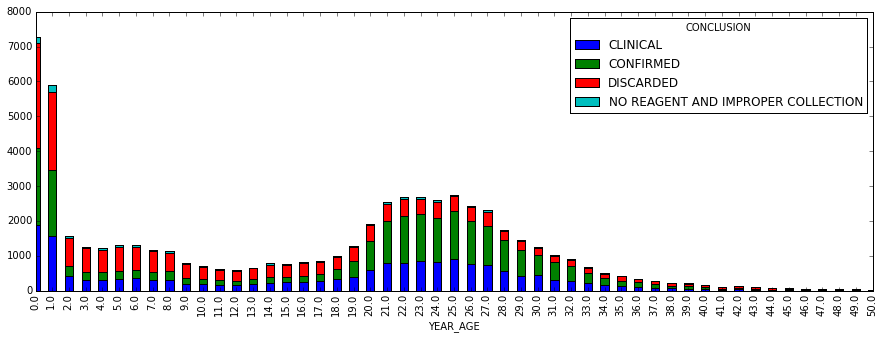

In [20]:
by_conclusion = measles_data.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5))

## Stochastic Disease Transmission Model

As a baseline for comparison, we can fit a model to all the clinically-confirmed cases, regardless of lab confirmation status. For this, we will use a simple SIR disease model, which will be fit using MCMC.

This model fits the series of 2-week infection totals in each district $i$ as a set of Poisson models:

\\[Pr(I(t)_{i} | \lambda(t)_i) = \text{Poisson}(\lambda(t)_i) \\]

Where the outbreak intensity is modeled as:

\\[\lambda(t)_i = \beta [I^{(w)}(t-1)_i]^{\alpha} S(t-1)_i\\]

\\[\alpha \sim \text{Exp}(1)\\]

We will assume here that the transmission rate is constant over time (and across districts):

\\[\beta \sim \text{Gamma}(1, 0.1)\\]

To account for the influence of infected individuals from neighboring districts on new infections, the outbreak intensity was modeled using a spatial-weighted average of infecteds across districts, where populations were weighted as an exponential function of the distance between district centroids:

\\[w_{d} = \text{exp}(-\theta d)\\]

\\[\theta \sim \text{Exp}(1)\\]

### Confirmation Sub-model

Rather than assume all clinical cases are true cases, we can adjust the model to account for lab confirmation probability. This is done by including a sub-model that estimates age group-specific probabilities of confirmation, and using these probabilities to estimate the number of lab-confirmed cases. These estimates are then plugged into the model in place of the clinically-confirmed cases.

We specified a structured confirmation model to retrospectively determine the age group-specific probabilities of lab confirmation for measles, conditional on clinical diagnosis. Individual lab confirmation events $c_i$ were modeled as Bernoulli random variables, with the probability of confirmation being allowed to vary by age group:

$$c_i \sim \text{Bernoulli}(p_{a(i)})$$

where $a(i)$ denotes the appropriate age group for the individual indexed by i. There were 16 age groups, the first 15 of which were 5-year age intervals $[0,5), [5, 10), \ldots , [70, 75)$, with the 16th interval including all individuals 75 years and older.

Since the age interval choices were arbitrary, and the confirmation probabilities of adjacent groups likely correlated, we modeled the correlation structure directly, using a multivariate logit-normal model. Specifically, we allowed first-order autocorrelation among the age groups, whereby the variance-covariance matrix retained a tridiagonal structure. 

$$\begin{aligned}
\Sigma = \left[{
\begin{array}{c}
  {\sigma^2} & {\sigma^2 \rho} & 0& \ldots & {0} & {0}  \\
  {\sigma^2 \rho} & {\sigma^2} &  \sigma^2 \rho & \ldots & {0}  & {0} \\
  {0} & \sigma^2 \rho & {\sigma^2} & \ldots & {0} & {0} \\
  \vdots & \vdots & \vdots &  & \vdots & \vdots\\
  {0} & {0} & 0 & \ldots &  {\sigma^2} & \sigma^2 \rho  \\
{0} & {0} & 0 & \ldots & \sigma^2 \rho &  {\sigma^2} 
\end{array}
}\right]
\end{aligned}$$

From this, the confirmation probabilities were specified as multivariate normal on the inverse-logit scale.

$$ \text{logit}(p_a) = \{a\} \sim N(\mu, \Sigma)$$

Priors for the confirmation sub-model were specified by:

$$\begin{aligned}
\mu_i &\sim N(0, 100) \\
\sigma &\sim \text{HalfCauchy}(25) \\
\rho &\sim U(-1, 1)
\end{aligned}$$

Age classes are defined in 5-year intervals.

In [21]:
age_classes = [0,5,10,15,20,25,30,35,40,100]
measles_data.dropna(subset=['YEAR_AGE'], inplace=True)
measles_data['YEAR_AGE'] = measles_data.YEAR_AGE.astype(int)
measles_data['AGE_GROUP'] = pd.cut(measles_data.AGE, age_classes, right=False)

Lab-checked observations are extracted for use in estimating lab confirmation probability.

In [22]:
CONFIRMED = measles_data.CONCLUSION == 'CONFIRMED'
CLINICAL = measles_data.CONCLUSION == 'CLINICAL'
DISCARDED = measles_data.CONCLUSION == 'DISCARDED'

Extract confirmed and clinical subset, with no missing county information.

In [23]:
lab_subset = measles_data[(CONFIRMED | CLINICAL) & measles_data.COUNTY.notnull()].copy()

In [24]:
age = lab_subset.YEAR_AGE.values
ages = lab_subset.YEAR_AGE.unique()
counties = lab_subset.COUNTY.unique()
y = (lab_subset.CONCLUSION=='CONFIRMED').values

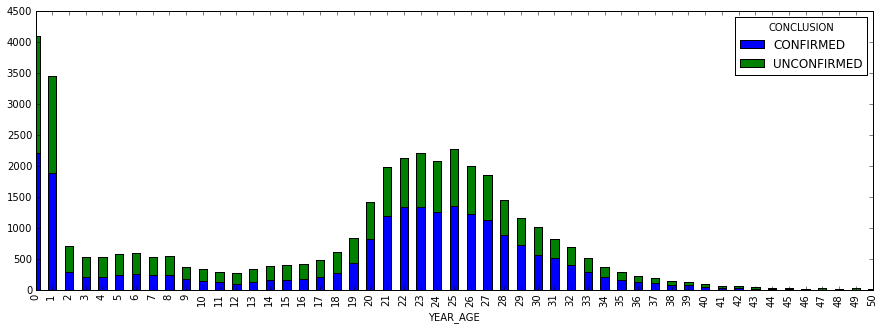

In [25]:
_lab_subset = lab_subset.replace({"CONCLUSION": {"CLINICAL": "UNCONFIRMED"}})
by_conclusion = _lab_subset.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5), grid=False)

Proportion of lab-confirmed cases older than 20 years

In [26]:
(measles_data[CONFIRMED].YEAR_AGE>20).mean()

0.60257048468117846

In [27]:
#Extract cases by age and time.
age_group = pd.cut(age, age_classes, right=False)
age_index = np.array([age_group.categories.tolist().index(i) for i in age_group])
age_groups = age_group.categories
age_groups

Index(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)',
       '[30, 35)', '[35, 40)', '[40, 100)'],
      dtype='object')

In [28]:
# Get index from full crosstabulation to use as index for each district
dates_index = measles_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().index

In [29]:
unique_districts = measles_data.DISTRICT.dropna().unique()

In [64]:
excludes = ['BOM RETIRO']

N = sp_pop.drop(excludes).ix[unique_districts].sum().drop('Total')
N

0 a 4 anos      844130
5 a 9 anos      830880
10 a 14 anos    858750
15 a 19 anos    904972
20 a 24 anos    945244
25 a 29 anos    902086
30 a 34 anos    835888
35 a 39 anos    764605
40 a 44 anos    662946
45 a 49 anos    538872
50 a 54 anos    437744
55 a 59 anos    332195
60 a 64 anos    282850
65 a 69 anos    218202
70 a 74 anos    164842
75 anos e +     203482
dtype: float64

In [84]:
N_age = N.iloc[:8]
N_age.index = age_groups[:-1]
N_age[age_groups[-1]] = N.iloc[8:].sum()
N_age

[0, 5)        844130
[5, 10)       830880
[10, 15)      858750
[15, 20)      904972
[20, 25)      945244
[25, 30)      902086
[30, 35)      835888
[35, 40)      764605
[40, 100)    2841133
dtype: float64

Calcualte average susceptibility over age groups

In [96]:
age_slice_endpoints = [g[1:-1].split(',') for g in age_groups.values]
age_slices = [slice(int(i[0]), int(i[1])) for i in age_slice_endpoints]

In [112]:
p_susc_age = np.array([total_susc[s].mean() for s in age_slices])

Compile bi-weekly confirmed and unconfirmed data by Sao Paulo district

In [31]:
sp_counts_2w = lab_subset.groupby(
    ['ONSET', 'AGE_GROUP']).size().unstack().reindex(dates_index).fillna(0).resample('2W', how='sum')

# All confirmed cases, by district
confirmed_data = lab_subset[lab_subset.CONCLUSION=='CONFIRMED']
confirmed_counts = confirmed_data.groupby(
    ['ONSET', 'AGE_GROUP']).size().unstack().reindex(dates_index).fillna(0).sum()

all_confirmed_cases = confirmed_counts.reindex_axis(measles_data['AGE_GROUP'].unique()).fillna(0)

In [32]:
# Ensure the age groups are ordered
I_obs = sp_counts_2w.reindex_axis(measles_data['AGE_GROUP'].unique(), 
                            axis=1).fillna(0).values.astype(int)

Check shape of data frame

- 28 bi-monthly intervals, 9 age groups

In [33]:
assert I_obs.shape == (28, len(age_groups))

Prior distribution on susceptible proportion:

$$p_s \sim \text{Beta}(5, 100)$$

(array([  6.09000000e+02,   2.84900000e+03,   3.25800000e+03,
          2.03400000e+03,   8.66000000e+02,   2.76000000e+02,
          8.40000000e+01,   1.70000000e+01,   4.00000000e+00,
          3.00000000e+00]),
 array([ 0.00296857,  0.02012682,  0.03728508,  0.05444333,  0.07160158,
         0.08875984,  0.10591809,  0.12307634,  0.1402346 ,  0.15739285,
         0.1745511 ]),
 <a list of 10 Patch objects>)

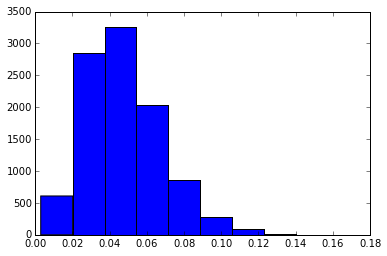

In [34]:
from pymc import rbeta
plt.hist(rbeta(5, 100, 10000))

In [35]:
I_obs

array([[   1,    3,    0,    1,    0,    0,    0,    0,    1],
       [   4,   13,    7,   18,    1,    2,    0,    1,    4],
       [   3,   12,    2,   14,    0,    1,    1,    2,    5],
       [   4,   10,    2,   17,    0,    2,    2,    2,    2],
       [   6,   15,    7,   19,    1,    3,    1,    7,    6],
       [  19,   27,   20,   34,    0,    7,    2,   13,    8],
       [   9,   27,    6,   26,    1,    1,    1,    6,    8],
       [  13,   27,   13,   20,    1,    4,    2,    5,    2],
       [  28,   32,   16,   21,    2,    6,    1,    9,    9],
       [  42,   39,   46,   31,    6,   17,    2,   13,   18],
       [  93,   69,   72,   40,    4,   18,    6,   19,   26],
       [ 157,   95,  153,   64,   12,   47,    5,   31,   42],
       [ 359,  183,  315,  169,   26,   95,   18,   76,   68],
       [ 807,  363,  622,  282,   65,  234,   34,  162,  136],
       [1168,  660, 1035,  388,   87,  398,   63,  257,  166],
       [1442,  913, 1193,  536,  137,  430,   48,  318,

In [36]:
# Extract observed data
obs_date = '1997-06-15'
obs_index = sp_counts_2w.index <= obs_date
I_obs_t = I_obs[obs_index]

# Specify confirmation model
confirmation = True

In [114]:
from pymc3 import *
import theano.tensor as tt
from theano.tensor.nlinalg import matrix_inverse as inv
invlogit = tt.nnet.sigmoid

with Model() as model:
    
    n_periods, n_groups = I_obs_t.shape
    
    if confirmation:
    
        mu = Normal('mu', mu=0, tau=0.0001, shape=n_groups)
        sig = HalfCauchy('sig', 25, shape=n_groups, testval=np.ones(n_groups))

        Tau = tt.diag(tt.pow(sig, -2)) 

        # Age-specific probabilities of confirmation as multivariate normal 
        # random variables
        beta_age = MvNormal('beta_age', mu=mu, tau=Tau, 
                            shape=n_groups)

        p_age = Deterministic('p_age', invlogit(beta_age))

        p_confirm = invlogit(beta_age[age_index])

        # Confirmation likelihood
        lab_confirmed = Bernoulli('lab_confirmed', p=p_confirm, observed=y)

        # Confirmed infecteds by age
        I_conf = Binomial('I_conf', I_obs_t, p_age, shape=I_obs_t.shape)

        I = I_conf.sum(1)
        
    else:
        
        I = I_obs_t.sum(1)
    
    # Estimated total initial susceptibles
    S_0 = Binomial('S_0', n=N_age.values, p=p_susc_age, shape=N_age.shape)

    # Susceptibles at each time step (subtract cumulative cases from initial S)
    S = S_0.sum() - I.cumsum()
    
    # Transmission parameter
    beta = Uniform('beta', 1, 100)         

    # Force of infection
    lam = beta * I * S / N_age.sum()
    
    # Likelihood of observed cases as function of FOI of prevous period
    like = Potential('like', 
            dist_math.logpow(lam[:-1], I[1:]) - dist_math.factln(I[1:]) - lam[:-1])

In [115]:
iterations = 20000
burn = 10000

In [120]:
with model:
    start = find_MAP()
    step1 = NUTS(vars=model.cont_vars, scaling=start)
    step2 = Metropolis(vars=model.disc_vars)
    
    trace = sample(iterations, step=steps, start=start)
    

 [-----------------100%-----------------] 20000 of 20000 complete in 160.7 sec

/Users/fonnescj/anaconda3/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  return f(*args, **kwds)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118843908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11886c358>]], dtype=object)

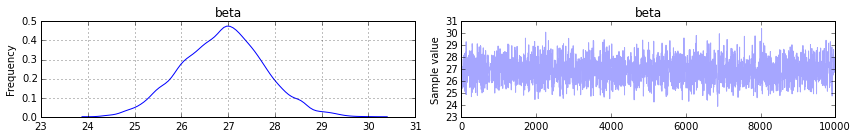

In [117]:
traceplot(trace[burn:], vars=['beta'])

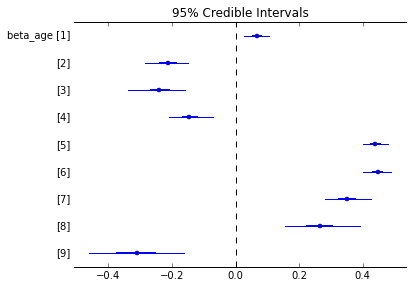

In [118]:
forestplot(trace[burn:], vars=['beta_age'])